In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

In [111]:
df = pd.read_csv('..\DATA\Frozen_Dessert_Production.csv', parse_dates=True, index_col = 'DATE')

In [112]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


<AxesSubplot:xlabel='DATE'>

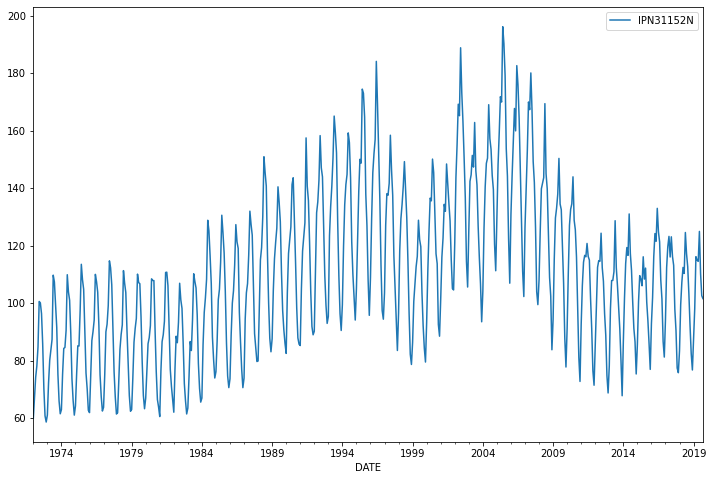

In [114]:
df.plot(figsize = (12,8))

In [115]:
len(df)

573

In [116]:
test_size = 24

In [117]:
test_ind = len(df)-test_size

In [118]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [119]:
len(train)

549

In [120]:
len(test)

24

In [121]:
from sklearn.preprocessing import MinMaxScaler

In [122]:
scaler = MinMaxScaler()

In [123]:
scaler.fit(train)

MinMaxScaler()

In [124]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [125]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [126]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
val_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size=1)

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [128]:
n_features=1

In [129]:
model = Sequential()

model.add(LSTM(150, activation='relu', input_shape = (length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [130]:
from tensorflow.keras.callbacks import EarlyStopping

In [131]:
early = EarlyStopping(monitor = 'val_loss', patience=3)

In [132]:
model.fit(generator,
          epochs=50,
         validation_data = val_generator,
          callbacks = [early]
         )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 537 steps, validate for 12 steps
Epoch 1/50
537/537 [==============================] - 21s 39ms/step - loss: 0.0230 - val_loss: 0.0089
Epoch 2/50
537/537 [==============================] - 16s 29ms/step - loss: 0.0084 - val_loss: 0.0021
Epoch 3/50
537/537 [==============================] - 16s 30ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 4/50
537/537 [==============================] - 19s 36ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 5/50
537/537 [==============================] - 16s 31ms/step - loss: 0.0046 - val_loss: 0.0026


In [133]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [134]:
loss = pd.DataFrame(model.history.history)

<AxesSubplot:>

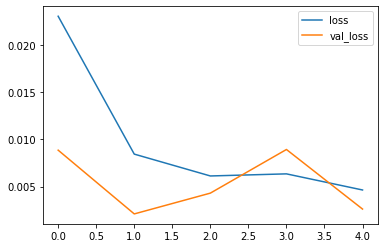

In [135]:
loss.plot()

In [136]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [137]:
true_predictions = scaler.inverse_transform(test_predictions)

In [138]:
test['LSTM predictions'] = true_predictions

C:\Users\roshan\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [139]:
test.head()

,IPN31152N,LSTM predictions
DATE,,
2017-10-01,90.4732,89.046911
2017-11-01,77.4378,81.261767
2017-12-01,75.8118,79.293498
2018-01-01,83.4343,87.395516
2018-02-01,99.4899,98.799617


<AxesSubplot:xlabel='DATE'>

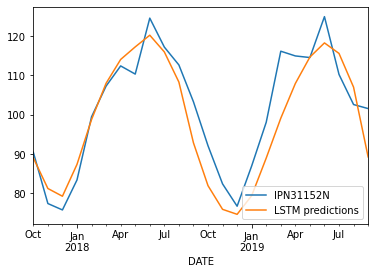

In [140]:
test.plot()

In [141]:
scaler = MinMaxScaler()

In [144]:
df_scale = scaler.fit_transform(df)

In [145]:
length=12

In [146]:
full_gen = TimeseriesGenerator(df_scale, df_scale, length = length, batch_size=1)

In [148]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit(full_gen,epochs=5)

  ...
    to  
  ['...']
Train for 561 steps
Epoch 1/5
561/561 [==============================] - 20s 36ms/step - loss: 0.0228
Epoch 2/5
561/561 [==============================] - 16s 29ms/step - loss: 0.0106
Epoch 3/5
561/561 [==============================] - 19s 34ms/step - loss: 0.0055
Epoch 4/5
561/561 [==============================] - 19s 34ms/step - loss: 0.0048
Epoch 5/5
561/561 [==============================] - 18s 33ms/step - loss: 0.0039 2 - ETA: 1s - loss: 0.00


In [149]:
forecast = []
period=12
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(period):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [150]:
forecast = scaler.inverse_transform(forecast)

In [152]:
forecast

array([[ 89.44532903],
       [ 81.85265052],
       [ 81.99549241],
       [ 92.5636934 ],
       [105.28181749],
       [114.13740356],
       [118.03213525],
       [119.98060353],
       [119.52753561],
       [113.94188913],
       [103.59739021],
       [ 89.71992093]])

In [153]:
test

,IPN31152N,LSTM predictions
DATE,,
2017-10-01,90.4732,89.046911
2017-11-01,77.4378,81.261767
2017-12-01,75.8118,79.293498
2018-01-01,83.4343,87.395516
2018-02-01,99.4899,98.799617
2018-03-01,107.3152,108.025179
2018-04-01,112.4309,114.077459
2018-05-01,110.3544,117.266745
2018-06-01,124.5841,120.240854


In [155]:
forecast_ind = pd.date_range(start='2019-10-01',periods=period,freq='MS')

In [157]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_ind,
                           columns=['Forecast'])

In [158]:
forecast_df

,Forecast
2019-10-01,89.445329
2019-11-01,81.852651
2019-12-01,81.995492
2020-01-01,92.563693
2020-02-01,105.281817
2020-03-01,114.137404
2020-04-01,118.032135
2020-05-01,119.980604
2020-06-01,119.527536
2020-07-01,113.941889


<AxesSubplot:>

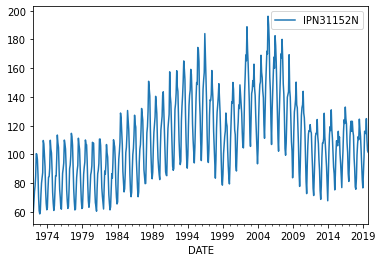

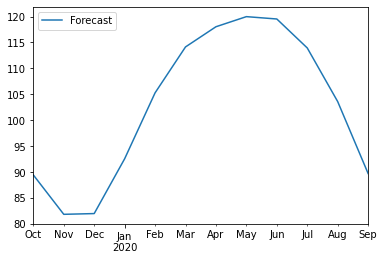

In [160]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

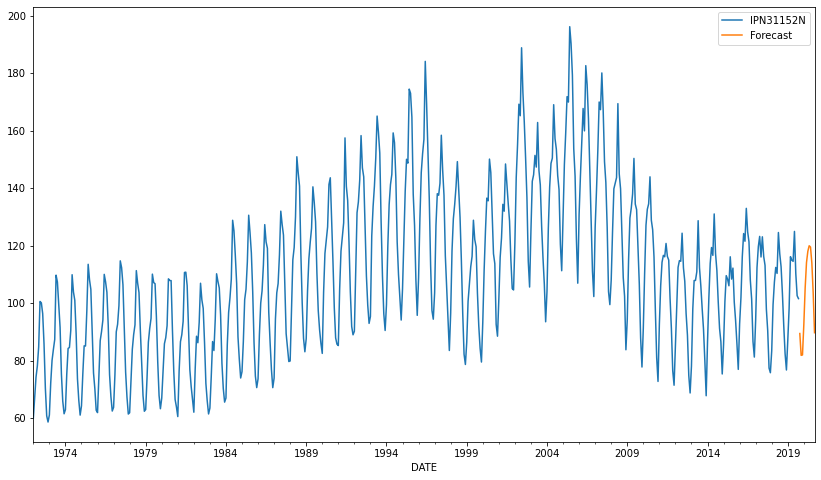

In [161]:
ax = df.plot(figsize=(14,8))
forecast_df.plot(ax=ax)